In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')


In [20]:
def create_df(path):
    with open(path) as fi:
        data = fi.read()
    data = data.split('\n')


    # construct protein ID and fasta sequence
    prot_id = []
    seqs = []
    for i in range(1, len(data), 2):
        prot_id.append(data[i-1].replace(">", ""))
        seqs.append(data[i])
        
    df = {'Protein ID': prot_id, 'simple_fasta': seqs}
    df = pd.DataFrame(df)
    return df

In [21]:
# make dataframe from every temperature cluster
df1 = create_df('../data/Hyperthermophiliccd_hit_out')
df2 = create_df('../data/Mesophiliccd_hit_out')
df3 = create_df('../data/Thermophiliccd_hit_out')


# concatenate dataframes
frames = [df1, df2, df3]
df = pd.concat(frames)


# merge with filtered dataframe dataframe by Protein ID and simple_fasta
tm_per_seq = pd.read_csv('../data/filtered_data.csv')
filtered_seqs = pd.merge(df, tm_per_seq, how ='inner', on = ['Protein ID', 'simple_fasta'])


# read blind test data and exclude these sequences from train
test = pd.read_csv('../data/test_dataset.csv').iloc[:, 1:]
exclude_group = list(set(filtered_seqs['Protein ID']).intersection(set(test['Protein ID'])))
train = filtered_seqs.loc[~filtered_seqs['Protein ID'].isin(exclude_group)]

In [22]:
df = pd.concat([train, test])

In [23]:
y = df['Tm'].apply(lambda x: 1 if x <= 45 else 2 if (45 < x < 75) else 3)

In [24]:
df['Категория'] = y
df['Protein ID'] = df['Protein ID'].apply(lambda x: x.split('_')[0])

In [25]:
df.head()

,Protein ID,simple_fasta,Species,Tm,Категория
12,A0A0K2H9C7,MKRWLFAVSCAALLLLGGCTTKSEPKRAEPAKPAPRQEQPSKPPAE...,G.stearothermophilus,75.067,3
13,A0A0K2H563,MRIDILTLFPGMFSGVLNESILKKAQEKGAVDIRLIDFREFADNKH...,G.stearothermophilus,75.074,3
14,A0A0K2H825,MHIYRYEENPLITPEDVPPHHDGFEVIGAFNAGVARFQGEVLLLLR...,G.stearothermophilus,75.087,3
15,A0A0K2HAE8,MEEWPLRLFGWFFLSLLANALFASAEAAFSSASKARLRHYAEEHLH...,G.stearothermophilus,75.089,3
16,A0A0K2H9B8,MIERYTRPEMGAIWTEENRFKAWLEVELLACEAWAELGVIPKEDVR...,G.stearothermophilus,75.095,3


In [27]:
group_dict = {'charge' : ['R', 'H', 'K', 'D', 'E'], 'polar': ['S', 'T', 'N', 'Q'],  'cyctein': ['C'], 
             'glicin': ['G'], 'prolin' : ['P'], 'hydr' : ['A', 'V', 'I', 'L', 'M', 'F', 'Y', 'W']}

In [28]:
ss_df = pd.read_csv('../data/ss_stat.csv')
ss_df.columns = ['Protein ID', 'disord', 'sheet', 'helix', 'sar']

In [29]:
df = df.merge(ss_df, how='inner', on='Protein ID')

In [30]:
df.Категория.value_counts()

2    10747
1     5812
3     1229
Name: Категория, dtype: int64

In [31]:
one = df[df.Категория==1].sample(n = 1229)
two = df[df.Категория==2].sample(n = 1229)
three = df[df.Категория==3]
overall = pd.concat([one, two, three])

In [32]:
overall.Категория.value_counts()

1    1229
2    1229
3    1229
Name: Категория, dtype: int64

In [33]:
overall.head()

,Protein ID,simple_fasta,Species,Tm,Категория,disord,sheet,helix,sar
1366,Q42577,MAMITRNTATRLPLLLQSQRAVAAASVSHLHTSLPALSPSTSPTSY...,A.thaliana,38.395,1,46343377233231153544,551513,542083391533176,16985
1668,Q9LRS2,MKSSSSIFRETSEKKSERWMMMNIGRFSPFFLSSFCITLFFTGFFV...,A.thaliana,42.155,1,29227291514146445122232828385552221210,5565577125561511511,181243371424331846195314,24423
2413,O31749,MEKPKYKRIVLKLSGEALAGEQGNGINPTVIQSIAKQVKEIAELEV...,B.subtilis,42.175,1,1325474581394511117455,66525622253,37156241911697,12152
1689,O80585,MKVIDKIQSLADEGKTAFSFEFFPPKTEDGVDNLFERMDRMVAYGP...,A.thaliana,42.351,1,2455325442723458436553451525314113617132131154...,646151642252654773767,10153131332123162131111021933373541113391122135,26906
5474,P77775,MNIVITGGTGLIGRHLIPRLLELGHQITVVTRNPQKASSVLGPRVT...,E.coli,42.471,1,14324121272632714651457329,564452731235212,12823441411131111758,13890


In [41]:
def stat_test(feature: str) -> float:
    s_1 = overall.loc[overall['Категория']==1].loc[:, feature].values
    s_2 = overall.loc[overall['Категория']==3].loc[:, feature].values
    s_3 = overall.loc[overall['Категория']==3].loc[:, feature].values
    
    _, pval_1 = stats.ttest_ind(a=s_1, b=s_3, equal_var=False)
    _, pval_2 = stats.ttest_ind(a=s_2, b=s_3, equal_var=False)
    return pval_1, pval_2

##### count physico-chemical group of aminoacid per sequence

In [36]:
def count_group_aa(group_dict, df):
    seqs = list(df.simple_fasta)
    for key in group_dict:
        stat = []
        for seq in seqs:
            a = 0
            for ch in group_dict[key]:
                a += seq.count(ch)
            stat.append(a)
        df[key] = np.array(stat)
    

In [37]:
count_group_aa(group_dict, overall)

In [38]:
def count_len(df): 
    seqs = list(df.simple_fasta)
    lengths =  np.array([len(seq) for seq in seqs])
    df['length_seq'] = lengths 

In [39]:
count_len(overall)

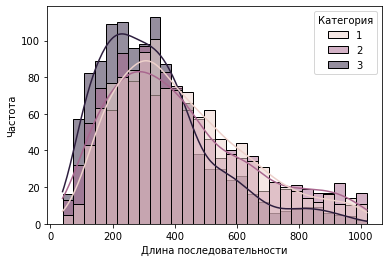

In [40]:
z = sns.histplot(overall, x='length_seq', hue='Категория',  kde=True);
z.set_xlabel('Длина последовательности')
z.set_ylabel('Частота')
plt.show()

In [44]:
pval_1, pval_2 = stat_test('length_seq')

In [45]:
pval_1, pval_2

(3.1721931337215386e-29, 1.0)

In [47]:
overall['charge_norm'] = overall['charge']/overall['length_seq']

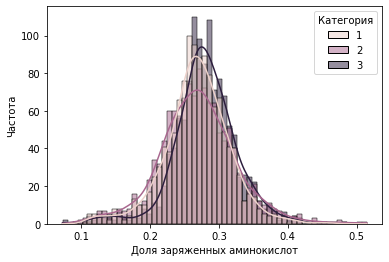

In [48]:
z = sns.histplot(overall, x='charge_norm', hue='Категория',  kde=True)
z.set_xlabel('Доля заряженных аминокислот')
z.set_ylabel('Частота')
plt.show()

In [49]:
p_value = stat_test('charge_norm')
p_value

(3.4606620961480806e-09, 1.0)

In [50]:
overall['polar_norm'] = overall['polar']/overall['length_seq']

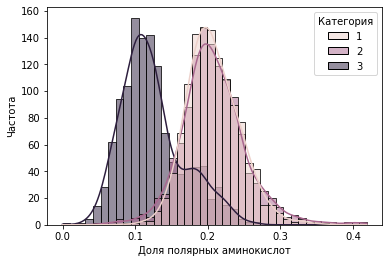

In [51]:
z = sns.histplot(overall, x='polar_norm', hue='Категория',  kde=True)
z.set_xlabel('Доля полярных аминокислот')
z.set_ylabel('Частота')
plt.show();

In [52]:
p_value = stat_test('polar_norm')
p_value

(0.0, 1.0)

In [53]:
overall['hydr_norm'] = overall['hydr']/overall['length_seq']

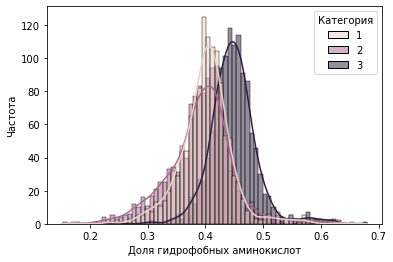

In [54]:
z = sns.histplot(overall, x='hydr_norm', hue='Категория',  kde=True)
z.set_xlabel('Доля гидрофобных аминокислот')
z.set_ylabel('Частота')
plt.show()

In [55]:
p_value = stat_test('hydr_norm')
p_value

(3.241645274475708e-140, 1.0)

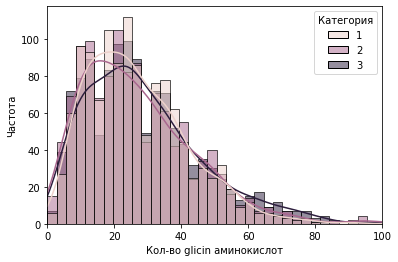

In [56]:
z = sns.histplot(overall, x='glicin', hue='Категория',  kde=True)
z.set_xlabel('Кол-во glicin аминокислот')
z.set_ylabel('Частота')
z.set_xlim(0, 100)
plt.show()

In [57]:
p_value = stat_test('glicin')
p_value

(0.007587416202053288, 1.0)

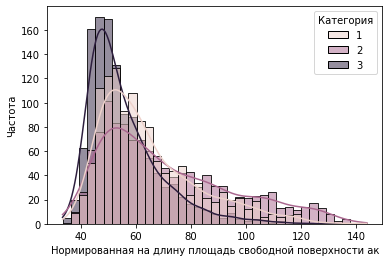

In [58]:
overall['sar_normalized'] = overall.sar/overall.length_seq # normalized sar
z = sns.histplot(data=overall, x='sar_normalized', hue='Категория',  kde=True)
z.set_xlabel('Нормированная на длину площадь свободной поверхности ак')
z.set_ylabel('Частота')
plt.show()

In [59]:
p_value = stat_test('sar_normalized')
p_value

(4.0919986942666716e-42, 1.0)